In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import sys
import random
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm_notebook as tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from datetime import datetime
import utils
from unetEnums import DataType
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from skimage.morphology import watershed
from skimage.feature import peak_local_max
from utils import SubstractContourSingleMask, GetBinaryContourMapSingleMask, GetSpaceBetweenTouchingMasks

np.set_printoptions(threshold=np.inf)

# Set some parameters
imgWidth = 512
imgHeight = 512
imgChannels = 3
_trainPath = '../../datasets/2018_dsb/stage1_train_fixed/'
_testPath = '../../datasets/2018_dsb/stage2_test_final/'
_extraDataPath = '../../datasets/2018_dsb/extra_data/'
# Root directory of the project
_rootDir = os.getcwd()
# Directory to save logs and trained model
_modelDir = os.path.join(_rootDir, "logs")


masks = np.zeros((1, imgHeight, imgWidth, 1), dtype=np.bool)
spaceBetween = np.zeros((1, imgHeight, imgWidth, 1), dtype=np.bool)

contourThickness = 1
path = "./stage1_train_fixed/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552"
mask = np.zeros((imgHeight, imgWidth, 1), dtype=np.int)
overlappingContourMapAllObjects = np.zeros((imgHeight, imgWidth), dtype=np.int)
combinedContours = np.zeros((imgHeight, imgWidth), dtype=np.int)
for mask_file in next(os.walk(path + '/masks/'))[2]:
    mask_ = imread(path + '/masks/' + mask_file, as_gray = False)
    mask_ = resize(image = mask_, output_shape=(imgHeight, imgWidth), order=0, mode='constant', cval=0, clip=True, preserve_range=True, anti_aliasing=True, anti_aliasing_sigma=None)
    combinedContours = np.maximum(combinedContours, GetBinaryContourMapSingleMask(mask_, contourThickness))
    overlappingContourMapAllObjects = np.add(GetBinaryContourMapSingleMask(mask_, contourThickness), overlappingContourMapAllObjects)
    mask_ = np.expand_dims(mask_, axis=-1) 
    mask = np.maximum(mask, mask_)

print(mask.dtype)
print(GetSpaceBetweenTouchingMasks(overlappingContourMapAllObjects).dtype)
imshow(np.squeeze(mask))
plt.show()
mask = np.subtract(mask, GetSpaceBetweenTouchingMasks(overlappingContourMapAllObjects))
mask[mask<0]=0
mask = mask.astype(np.bool)
imshow(combinedContours)
plt.show()
spaceB = GetSpaceBetweenTouchingMasks(overlappingContourMapAllObjects).astype(np.bool)
imshow(np.squeeze(spaceB))
plt.show()
print(mask.shape)
imshow(np.squeeze(mask))
plt.show()
print(mask.dtype)

masks[0] = mask
spaceBetween = spaceB

Using TensorFlow backend.


StopIteration: 

(512, 512, 1)
(512, 512, 1)
(1, 512, 512, 2)
(512, 512, 2)


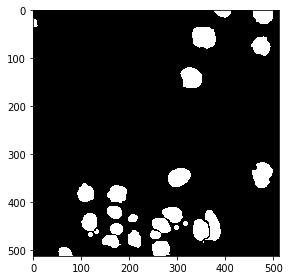

In [7]:
#combine masks with spaceBetween masks to get a numpy array of shape (len(ids), imgHeight, imgWidth, 2)

len = 1

combined = np.zeros((len, imgHeight, imgWidth, 2), dtype=np.bool)

print(mask.shape)
print(spaceB.shape)
print(combined.shape)

c = np.concatenate([mask, spaceB], axis=-1)
print(c.shape)

m, s = np.split(c, 2, -1)
imshow(np.squeeze(m))
plt.show()

In [ ]:
train_ids, X_train, Y_train = utils.load_dataset(_trainPath, _imgWidth, _imgHeight, _imgChannels, datasetType = DataType.trainData)
image = X_train[46]
imshow(image)
plt.show()
mask = np.squeeze(Y_train[46])

(256, 256)


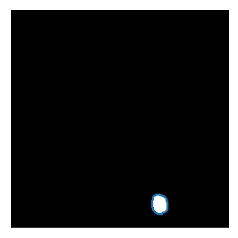

/tmp/scikit-image/skimage/io/_plugins/matplotlib_plugin.py:77: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


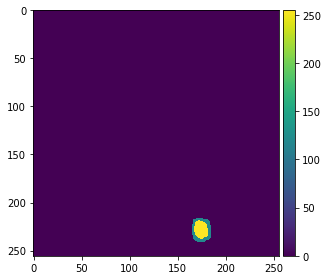

(256, 256)
(256, 256)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0

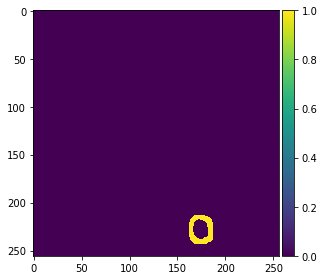

In [8]:
mask = imread("./stage1_train_fixed/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552/masks/aa154c70e0d82669e9e492309bd00536d2b0f6eeec1210014bbafbfc554b377c.png", as_gray = False)
print(mask.shape)
from skimage import measure
contours = measure.find_contours(mask, 1)


# Display the image and plot all contours found
fig, ax = plt.subplots()
ax.imshow(mask, interpolation='nearest', cmap=plt.cm.gray)

for n, contour in enumerate(contours):
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()


contourThickness = 1        
for n, contour in enumerate(contours):
    for i, coordinate in enumerate(contour):
        for j in range(-1*contourThickness, contourThickness+1):
            for y in range(-1*contourThickness, contourThickness+1):
                mask[coordinate[0].astype(np.int)+j][coordinate[1].astype(np.int)+y] = 120
imshow(mask)
plt.show()


print(mask.shape)
m = GetBinaryContourMapSingleMask(mask, 2)
print(m.shape)
print(m)
imshow(m)
plt.show()

In [9]:
###watershed###

path = "./stage1_train_fixed/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552"
masks = np.zeros((1, imgHeight, imgWidth, 1), dtype=np.bool)
mask = np.zeros((imgHeight, imgWidth, 1), dtype=np.bool)
for n, mask_file in next(os.walk(path + '/masks/'))[2]:
    mask_ = imread(path + '/masks/' + mask_file, as_gray = False)
    mask_ = resize(mask_, (imgHeight, imgWidth), mode='constant', preserve_range=True)
    mask_ = np.expand_dims(mask_, axis=-1)    
    mask = np.maximum(mask, mask_)
masks[n] = mask

imshow(np.squeeze(masks[0]))
plt.show()

mask = np.squeeze(masks[0])
# Now we want to separate the objects
# Generate the markers as local maxima of the distance to the background
distance = ndi.distance_transform_edt(mask)
local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3, 3)),
                            labels=mask)
markers = ndi.label(local_maxi)[0]
labels = watershed(-distance, markers, mask=mask)

fig, axes = plt.subplots(ncols=3, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(mask, cmap=plt.cm.gray, interpolation='nearest')
ax[0].set_title('Overlapping objects')
ax[1].imshow(-distance, cmap=plt.cm.gray, interpolation='nearest')
ax[1].set_title('Distances')
ax[2].imshow(labels, cmap=plt.cm.nipy_spectral, interpolation='nearest')
ax[2].set_title('Separated objects')

for a in ax:
    a.set_axis_off()

fig.tight_layout()
plt.show()
imshow(markers)
plt.show()

ValueError: too many values to unpack (expected 2)